In [1]:
import numpy as np 
import matplotlib.pylab as plt 
from scipy.integrate import dblquad, tplquad
from getdist import plots, MCSamples
import getdist
import torch 
import warnings
warnings.filterwarnings('ignore')

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
getdist.__version__

'1.3.0'

## Models 

$$\mathcal{M}_{1}: y= ax^{2}+bx$$

$$\mathcal{M}_{2}: y = ax^{2} + bx + c$$

$\mathcal{M}_{1}$ is nested in $\mathcal{M}_{2}$ at $c=0$. 

**Steps**

- Generate data using $\mathcal{M}_{1}$.
- Compute evidence analytically. 
- Compute evidence numerically. 
- Compute Bayes Factor. 
- Repeat 2-4 with the compression scheme. 

In [2]:
def model_1(xvalues: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    
    output = parameters[0]*xvalues**2 + parameters[1]*xvalues
    output = output.to(torch.float64)
    return output

def model_2(xvalues: torch.Tensor, parameters: torch.Tensor) -> torch.Tensor:
    
    output = parameters[0]*xvalues**2 + parameters[1]*xvalues + parameters[2]
    output = output.to(torch.float64)
    return output

In [3]:
xmin = 0.0
xmax = 4.0
npoint = 1000
xvals = torch.linspace(xmin, xmax, npoint)

a_param = -1.0
b_param = 4.0
c_param = 0.05

# model 1 
m1_parameters = torch.tensor([a_param, b_param])
m1_function = model_1(xvals, m1_parameters)

# model 2
m2_parameters = torch.tensor([a_param, b_param, c_param])
m2_function = model_2(xvals, m2_parameters)

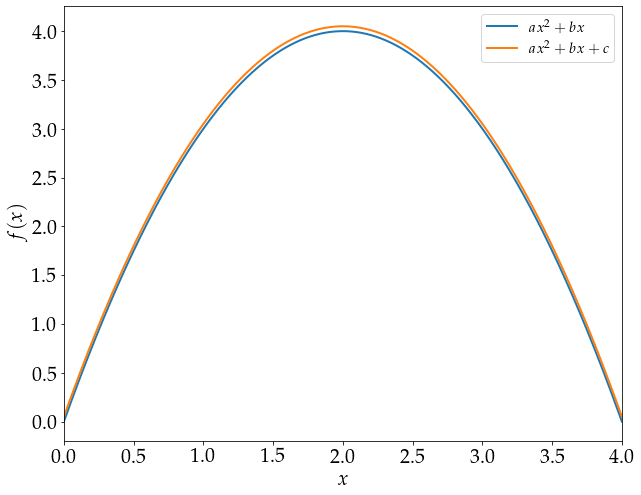

In [4]:
plt.figure(figsize = (10, 8))
plt.plot(xvals, m1_function, lw = 2, label = r'$ax^{2} + bx$')
plt.plot(xvals, m2_function, lw = 2, label = r'$ax^{2} + bx + c$')
plt.xlim(xmin, xmax)
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Data
The data is generated using Model 1.

In [5]:
ndata = 20
sigma = 0.2
xinputs = torch.linspace(xmin, xmax, ndata)
data = model_1(xinputs, m1_parameters) + torch.empty(ndata).normal_(mean=0.0,std=sigma)
data = data.type(torch.float64)

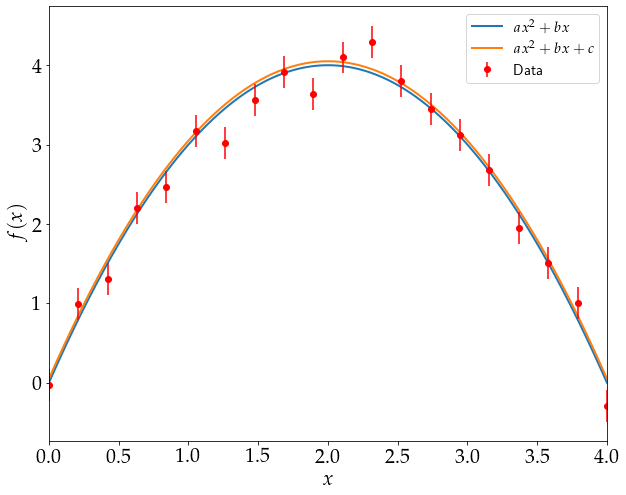

In [6]:
plt.figure(figsize = (10, 8))
plt.plot(xvals, m1_function, lw = 2, label = r'$ax^{2} + bx$')
plt.plot(xvals, m2_function, lw = 2, label = r'$ax^{2} + bx + c$')
plt.errorbar(xinputs, data, yerr = sigma, fmt = 'ro', label = 'Data')
plt.xlim(xmin, xmax)
plt.ylabel(r'$f(x)$', fontsize = fontSize)
plt.xlabel(r'$x$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Define all quantities 

In [7]:
cov = torch.from_numpy(np.diag([sigma**2] * ndata))
cov_inv = torch.from_numpy(np.diag([1/sigma**2] * ndata))

In [8]:
design_1 = torch.zeros((ndata, 2), dtype = float)
design_1[:,0] = xinputs**2
design_1[:,1] = xinputs

In [9]:
design_2 = torch.zeros((ndata, 3), dtype = float)
design_2[:,0] = xinputs**2
design_2[:,1] = xinputs
design_2[:,2] = torch.ones(ndata)

# Define the priors

We are assuming independent normal distribution. Multivariate normal distribution with the identity matrix as covariance. 

In [10]:
mu1 = torch.tensor([a_param, b_param], dtype = float)
mu2 = torch.tensor([a_param, b_param, c_param], dtype = float)

c1 = torch.eye(2, dtype = float)
c2 = torch.eye(3, dtype = float)

c1_inv = torch.linalg.inv(c1)
c2_inv = torch.linalg.inv(c2)

# Calculate the MAP (maximum a posteriori)

$$p(\boldsymbol{\theta}|\boldsymbol{y})=\mathcal{N}(\boldsymbol{\theta}|\boldsymbol{\Lambda}(\boldsymbol{\Phi}^{\textrm{T}}\boldsymbol{\Sigma}^{-1}\boldsymbol{y}+\mathbf{C}^{-1}\mathbf{m}), \boldsymbol{\Lambda})$$

where

- $\mathbf{m}$ is the mean prior. 
- $\mathbf{C}$ is the covariance of the prior. 
- $\boldsymbol{\Lambda} = (\mathbf{C}^{-1}+\boldsymbol{\Phi}^{\textrm{T}}\boldsymbol{\Sigma}^{-1}\boldsymbol{\Phi})^{-1}$

In [11]:
Lambda1 = torch.linalg.inv(c1_inv + design_1.t() @ cov_inv @ design_1)
Lambda2 = torch.linalg.inv(c2_inv + design_2.t() @ cov_inv @ design_2)

mean1 = design_1.t() @ cov_inv @ data + c1_inv @ mu1
mean1 = Lambda1 @ mean1

mean2 = design_2.t() @ cov_inv @ data + c2_inv @ mu2
mean2 = Lambda2 @ mean2

# Multivariate Posterior

We can just draw some samples and plot 1D and 2D marginal distributions.

In [12]:
nsamples = 10000
samples1 = np.random.multivariate_normal(mean1.numpy(), Lambda1.numpy(), nsamples)
samples2 = np.random.multivariate_normal(mean2.numpy(), Lambda2.numpy(), nsamples)

In [13]:
ndim1 = len(mean1)
ndim2 = len(mean2)

names1 = ["x%s"%i for i in range(ndim1)]
names2 = ["x%s"%i for i in range(ndim2)]

labels1 = ["a", "b"]
labels2 = ["a", "b", "c"]

mcSamples1 = MCSamples(samples=samples1, names = names1, labels = labels1)
mcSamples2 = MCSamples(samples=samples2, names = names2, labels = labels2)

Removed no burn in
Removed no burn in


In [19]:
mcSamples1.getCorrelationLength(1)

nan

# Posterior for First Model

ValueError: cannot convert float NaN to integer

<Figure size 432x324 with 0 Axes>

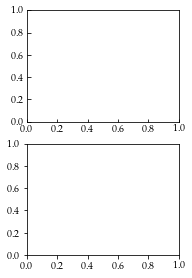

In [14]:
g = plots.get_single_plotter()
g.triangle_plot(mcSamples1, ['x0', 'x1'], filled=False)
plt.show()

## Posterior for Second Model

In [ ]:
g = plots.get_subplot_plotter()
g.triangle_plot([mcSamples2], ['x0', 'x1', 'x2'], filled=False)
plt.show()

# Evidence Computation

$$ p(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\boldsymbol{\Phi}\mathbf{m},\,\boldsymbol{\Sigma}+\boldsymbol{\Phi}\mathbf{C}\boldsymbol{\Phi}^{\textrm{T}})$$

In [ ]:
mean_data_1 = design_1 @ mu1
mean_data_2 = design_2 @ mu2

cov_data_1 = cov + design_1 @ c1 @ design_1.t()
cov_data_2 = cov + design_2 @ c2 @ design_2.t()

In [ ]:
data_pdf1 = torch.distributions.multivariate_normal.MultivariateNormal(mean_data_1, cov_data_1)
data_pdf2 = torch.distributions.multivariate_normal.MultivariateNormal(mean_data_2, cov_data_2)

In [ ]:
evi1 = data_pdf1.log_prob(data).item()
evi2 = data_pdf2.log_prob(data).item()

In [ ]:
print(f'The log-evidence of Model 1 is {evi1:.4f}')
print(f'The log-evidence of Model 2 is {evi2:.4f}')
print(f'The log-Bayes Factor between Model 1 and 2 is {evi1 - evi2:.4f}')

### Testing Numerical Integration

In [ ]:
def log_posterior_1(a, b):
    
    param = torch.tensor([a, b])
    model = model_1(xinputs, param)
    like = torch.distributions.multivariate_normal.MultivariateNormal(model, cov)
    prior = torch.distributions.multivariate_normal.MultivariateNormal(mu1, c1)
    
    return like.log_prob(data) + prior.log_prob(param)

In [ ]:
def log_posterior_2(a, b, c):
    
    param = torch.tensor([a, b, c])
    model = model_2(xinputs, param)
    like = torch.distributions.multivariate_normal.MultivariateNormal(model, cov)
    prior = torch.distributions.multivariate_normal.MultivariateNormal(mu2, c2)
    
    return like.log_prob(data) + prior.log_prob(param)

In [ ]:
logpost_max_1 = log_posterior_1(*mean1)
logpost_max_2 = log_posterior_2(*mean2)

In [ ]:
def posterior_1(a, b):
    
    post = log_posterior_1(a, b) - logpost_max_1
    
    return torch.exp(post)

def posterior_2(a, b, c):
    
    post = log_posterior_2(a, b, c) - logpost_max_2
    
    return torch.exp(post)

### Limits of integration

In [ ]:
nsigma = 5
lower_m1 = mean1 - nsigma * torch.sqrt(torch.diag(Lambda1))
upper_m1 = mean1 + nsigma * torch.sqrt(torch.diag(Lambda1))

lower_m2 = mean2 - nsigma * torch.sqrt(torch.diag(Lambda2))
upper_m2 = mean2 + nsigma * torch.sqrt(torch.diag(Lambda2))

The next cell is expensive to compute (for the triple integration).

In [ ]:
# num_m1 = dblquad(posterior_1, lower_m1[1], upper_m1[1], lambda b:lower_m1[0], lambda b: upper_m1[0])[0]
# num_m2 = tplquad(posterior_2, lower_m2[2], upper_m2[2], lambda c:lower_m2[1], lambda c: upper_m2[1], 
#                        lambda c, b: lower_m2[0], lambda c, b: upper_m2[0], epsabs=1.E-5, epsrel=1.E-5)[0]

In [ ]:
# numerical_m1 = torch.log(torch.exp(logpost_max_1) * num_m1).item()
# numerical_m2 = torch.log(torch.exp(logpost_max_2) * num_m2).item()

In [ ]:
# print(f'The log-evidence of Model 1 is {numerical_m1:.4f}')
# print(f'The log-evidence of Model 2 is {numerical_m2:.4f}')
# print(f'The log-Bayes Factor between Model 1 and 2 is {numerical_m1 - numerical_m2:.4f}')

# The log-evidence of Model 1 is 5.4914
# The log-evidence of Model 2 is 3.9619
# The log-Bayes Factor between Model 1 and 2 is 1.5295

# Compression

In [ ]:
# calculate the MOPED vectors (gradient is analytical)
moped_vectors_1 = cov_inv @ design_1
moped_vectors_2 = cov_inv @ design_2

In [ ]:
# calculate the compressed data vector 
moped_data1 = moped_vectors_1.t() @ data
moped_data2 = moped_vectors_2.t() @ data

In [ ]:
# calculate the product B Phi, Phi -> B Phi
B_Phi_1 = moped_vectors_1.t() @ design_1
B_Phi_2 = moped_vectors_2.t() @ design_2

In [ ]:
# the noise/data covariance matrix is changed 
new_cov1 = moped_vectors_1.t() @ cov @ moped_vectors_1
new_cov2 = moped_vectors_2.t() @ cov @ moped_vectors_2

new_cov1_inv = torch.linalg.inv(new_cov1)
new_cov2_inv = torch.linalg.inv(new_cov2)

In [ ]:
# calculate the covariance of the posterior 
moped_Lambda1 = torch.linalg.inv(c1_inv + B_Phi_1.t() @ new_cov1_inv @ B_Phi_1)
moped_Lambda2 = torch.linalg.inv(c2_inv + B_Phi_2.t() @ new_cov2_inv @ B_Phi_2)

In [ ]:
# calculate the mean of the posterior
moped_mean1 = B_Phi_1.t() @ new_cov1_inv @ moped_data1 + c1_inv @ mu1
moped_mean2 = B_Phi_2.t() @ new_cov2_inv @ moped_data2 + c2_inv @ mu2

moped_mean1 = moped_Lambda1 @ moped_mean1
moped_mean2 = moped_Lambda2 @ moped_mean2

# Triangle Plot

In [ ]:
samples_moped_1 = np.random.multivariate_normal(moped_mean1, moped_Lambda1, nsamples)
samples_moped_2 = np.random.multivariate_normal(moped_mean2, moped_Lambda2, nsamples)

In [ ]:
mcSamples_moped_1 = MCSamples(samples=samples_moped_1, names = names1, labels = labels1)
mcSamples_moped_2 = MCSamples(samples=samples_moped_2, names = names2, labels = labels2)

In [ ]:
g = plots.get_single_plotter()
g.triangle_plot([mcSamples1, mcSamples_moped_1], ['x0', 'x1'], filled=False, legend_labels=['No Compression', 'Compression'])
plt.show()

In [ ]:
g = plots.get_subplot_plotter()
g.triangle_plot([mcSamples2, mcSamples_moped_2], ['x0', 'x1', 'x2'], filled=False, legend_labels=['No Compression', 'Compression'])
plt.show()

# Analytical Evidence

In [ ]:
mean_data_moped_1 = B_Phi_1 @ mu1
mean_data_moped_2 = B_Phi_2 @ mu2

cov_data_moped_1 = new_cov1 + B_Phi_1 @ c1 @ B_Phi_1.t()
cov_data_moped_2 = new_cov2 + B_Phi_2 @ c2 @ B_Phi_2.t()

In [ ]:
data_moped_pdf1 = torch.distributions.multivariate_normal.MultivariateNormal(mean_data_moped_1, cov_data_moped_1)
data_moped_pdf2 = torch.distributions.multivariate_normal.MultivariateNormal(mean_data_moped_2, cov_data_moped_2)

In [ ]:
evi_moped_1 = data_moped_pdf1.log_prob(moped_data1).item()
evi_moped_2 = data_moped_pdf2.log_prob(moped_data2).item()

In [ ]:
print(f'MOPED: The log-evidence of Model 1 is {evi_moped_1:.4f}')
print(f'MOPED: The log-evidence of Model 2 is {evi_moped_2:.4f}')
print(f'MOPED: The log-Bayes Factor between Model 1 and 2 is {evi_moped_1 - evi_moped_2:.4f}')

# Using Sub-Blocks

In [ ]:
import torch.distributions.multivariate_normal as mn

In [ ]:
data_moped_sub_pdf1 = mn.MultivariateNormal(mean_data_moped_2[0:2], cov_data_moped_2[0:2, 0:2])
data_moped_sub_pdf2 = mn.MultivariateNormal(mean_data_moped_2, cov_data_moped_2)

In [ ]:
data_moped_sub_pdf1.log_prob(moped_data1).item()

In [ ]:
data_moped_sub_pdf2.log_prob(moped_data2).item()